# Task 7.1D: Function approximation implementation
_By Sudaksh Mishra (Student ID: 222348309)_

In [1]:
import gymnasium as gym
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
# Importing Taxi-v3 environment
env_name = 'Taxi-v3'
env = gym.make(env_name, render_mode='human')
observation, info = env.reset(seed=6)
print(list(env.decode(observation)))
# time.sleep(10)
env.close()

[2, 3, 1, 3]


In [3]:
num_states = env.observation_space.n
num_actions = env.action_space.n
print('Number of states:', num_states)
print('Number of actions:', num_actions)

Number of states: 500
Number of actions: 6


## Introduction
In reinforcement learning, agents learn to interact with an environment in order to maximize their cumulative reward. One of the most popular benchmarks for reinforcement learning is the Taxi-v3 problem, which involves a taxi navigating a grid-world environment to pick up and drop off passengers at specified locations.

In this report, we will discuss the implementation of two different temporal difference learning algorithms, namely semi-gradient SARSA(0) and semi-gradient TD(lambda), for solving the Taxi-v3 problem. Both algorithms are based on the concept of updating the agent's value function through trial-and-error interaction with the environment, and are well-suited for problems with small to medium-sized state and action spaces.

We will first provide a brief overview of the Taxi-v3 problem and the relevant reinforcement learning concepts. Then, we will describe the details of the semi-gradient SARSA(0) and semi-gradient TD(lambda) algorithms and explain how they were adapted and implemented for solving the Taxi-v3 problem.

## Taxi-v3 problem
The Taxi-v3 environment provides a 5x5 grid world with four possible locations for passengers and four possible destinations. The agent can move in any of the four cardinal directions (up, down, left, and right), as well as pick up and drop off passengers at specific locations. The rewards in the environment are based on the agent's actions and range from -1 for each time step to +20 for successfully dropping off a passenger.

The action shape is (1,) in the range {0, 5} indicating which direction to move the taxi or to pickup/drop off passengers.

- 0: Move south (down)
- 1: Move north (up)
- 2: Move east (right)
- 3: Move west (left)
- 4: Pickup passenger
- 5: Drop off passenger

Reference: https://gymnasium.farama.org/environments/toy_text/taxi/

### Semi-Gradient SARSA(0)

The semi-gradient SARSA(0) algorithm updates the action-value function for each state-action pair by taking a step in the direction of the gradient of the mean-squared error between the estimated action-value function and the true action-value function. This step size is controlled by a learning rate parameter, which determines the size of the updates.

In the name "Sarsa(0)", the 0 indicates that the algorithm uses a one-step update. This means that the update only considers the next state and action, rather than looking ahead at multiple future steps as in other algorithms like TD(lambda). In other words, Sarsa(0) updates its value estimates based on the immediate reward and the estimated value of the next state-action pair, without taking into account any subsequent rewards or state transitions. This makes the algorithm simpler and more computationally efficient than other TD-based methods, but also less accurate in some cases.

Pseudocode:
```
Loop for each episode:
    S, A <-- initial state and action of episode (e.g., env,reset)
    Loop for each step of episode:
        Take action A, observe R, S'
        If S' is terminal:
            w <-- w + alpha * (R - Q(S, A, w)) * grad Q(S, A, w)
            Go to next episode
        Choose A' as a function of Q(S', ., w) (e.g., epsilon-greedy)
        w <-- w + alpha * (R + gamma * Q(S', A', w) - Q(S, A, w)) * grad Q(S, A, w)
        S <-- S'; A <-- A'
    until S is terminal
```

Reference: Sutton, R.S. and Barto, A.G., 2018. Reinforcement learning: An introduction. MIT press.

In [4]:
class SemiGradientSarsa:
    def __init__(self, env_name, alpha=0.5, gamma=0.9, eps=1.0, seed=6):
        self.alpha = alpha
        self.gamma = gamma
        self.eps = eps
        self.seed = seed
        env = gym.make(env_name)
        observation, info = env.reset(seed=self.seed)
        if list(env.decode(observation))[2] == 0:
            self.passenger_location = (0, 0, 0)
        elif list(env.decode(observation))[2] == 1:
            self.passenger_location = (0, 0, 4)
        elif list(env.decode(observation))[2] == 2:
            self.passenger_location = (0, 4, 0)
        else:
            self.passenger_location = (0, 4, 3)

        if list(env.decode(observation))[3] == 0:
            self.destination = (1, 0, 0)
        elif list(env.decode(observation))[3] == 1:
            self.destination = (1, 0, 4)
        elif list(env.decode(observation))[3] == 2:
            self.destination = (1, 4, 0)
        else:
            self.destination = (1, 4, 3)
        env.close()
        self.theta = np.zeros(73)
        self.deltas = []

    def sa2x(self, s, a):
        x = np.zeros(73)

        for i in range(num_actions):
            x[0 + 12*i]  = s[0]/2 if a == i else 0
            x[1 + 12*i]  = s[1]/5 if a == i else 0
            x[2 + 12*i]  = s[2]/5 if a == i else 0
            x[3 + 12*i]  = s[0]*s[0]*s[1]/20 if a == i else 0
            x[4 + 12*i]  = s[0]*s[1]*s[1]/50 if a == i else 0
            x[5 + 12*i]  = s[0]*s[0]*s[2]/20 if a == i else 0
            x[6 + 12*i]  = s[0]*s[2]*s[2]/50 if a == i else 0
            x[7 + 12*i]  = s[1]*s[1]*s[2]/125 if a == i else 0
            x[8 + 12*i]  = s[1]*s[2]*s[2]/125 if a == i else 0
            x[9 + 12*i]  = s[0]*s[0]/25 if a == i else 0
            x[10 + 12*i] = s[1]*s[1]/25 if a == i else 0
            x[11 + 12*i] = s[2]*s[2]/25 if a == i else 0

        x[72] = 1
        return x

    def predict(self, s, a):
        x = self.sa2x(s, a)
        return self.theta.dot(x)
    
    def get_action(self, s):
        Qs = np.zeros(num_actions)
        for a in range(num_actions):
            Qs[a] = self.predict(s, a)
        return np.argmax(Qs), max(Qs)
    
    def random_action(self, action):
        p = np.random.rand()
        if p < self.eps:
            return np.random.choice([0, 1, 2, 3, 4, 5])
        else:
            return action
    
    def observation_prep(self, action, observation, observation_, reward, done, reward_given=False):
        # Adding the passenger state to the observation and adjusting the reward
        if action == 4 and observation == self.passenger_location:
            observation_ = tuple([1] + list(env.decode(observation_))[:2])
            # Reward for picking passenger up
            if not reward_given:
                reward_given = True
                reward = 10
        elif action == 5:
            observation_ = tuple([0] + list(env.decode(observation_))[:2])
            # Terminate the episode if there is an illegal drop off
            if observation != self.destination:
                done = True
                reward = -10
            else:
                reward = 20
        else:
            if observation[0] == 1:
                observation_ = tuple([1] + list(env.decode(observation_))[:2])
            else:
                observation_ = tuple([0] + list(env.decode(observation_))[:2])

        return observation_, reward, done, reward_given
        
    
    def train(self, num_episodes=8001, render_every=1000, eps_decay=1.0005, alpha_decay=1.0005, max_episode_steps=100):
        for i in range(num_episodes):
            # Render
            if i % render_every == 0:
                print('Episode:', i, 'eps:', self.eps, 'alpha:', self.alpha)
                if i != 0:
                    self.plot()
                env = gym.make(env_name, render_mode='human')
            else:
                env = gym.make(env_name)

            # Decay epsilon and alpha
            reward_given = False
            self.eps /= eps_decay
            self.alpha /= alpha_decay
            if self.alpha < 0.1:
                self.alpha = 0.1

            # Reset environment
            env._max_episode_steps = max_episode_steps
            observation, info = env.reset(seed=self.seed)
            observation = tuple([0] + list(env.decode(observation))[:2])
            done = False
            while not done:
                # Get action
                a, _ = self.get_action(observation)
                a = self.random_action(a)

                # Take action
                prev_observation = observation
                observation, reward, terminated, truncated, info = env.step(a)
                done = terminated or truncated
                observation, reward, done, reward_given = self.observation_prep(a, prev_observation, observation, reward, done, reward_given)

                # Update theta
                theta_old = self.theta.copy()
                if done:
                    self.theta += self.alpha*(reward - self.predict(prev_observation, a))*self.sa2x(prev_observation, a)
                else:
                    _, maxQ_ = self.get_action(observation)
                    self.theta += self.alpha*(reward + self.gamma*maxQ_ - self.predict(prev_observation, a))*self.sa2x(prev_observation, a)
            env.close()

            # Plotting
            self.deltas.append(np.abs(self.theta - theta_old).sum())

        clear_output(wait=True)
        env.close()

    def test(self, max_episode_steps=100):
        env = gym.make(env_name, render_mode='human')
        env._max_episode_steps = max_episode_steps
        observation, info = env.reset(seed=self.seed)
        observation = tuple([0] + list(env.decode(observation))[:2])
        reward_given = False
        reward_sum = 0
        done = False
        while not done:
            # Get action
            a, _ = self.get_action(observation)

            # Take action
            prev_observation = observation
            observation, reward, terminated, truncated, info = env.step(a)
            reward_sum += reward
            print('State:', observation, ' Action:', a, 'Reward:', reward)
            done = terminated or truncated
            observation, reward, done, reward_given = self.observation_prep(a, prev_observation, observation, reward, done, reward_given)
        print('Reward:', reward_sum)
        env.close()
    
    def plot(self):
        plt.plot(self.deltas)
        plt.show()

Episode: 0 eps: 1.0 alpha: 0.15
Episode: 8000 eps: 0.01833395757947439 alpha: 0.1


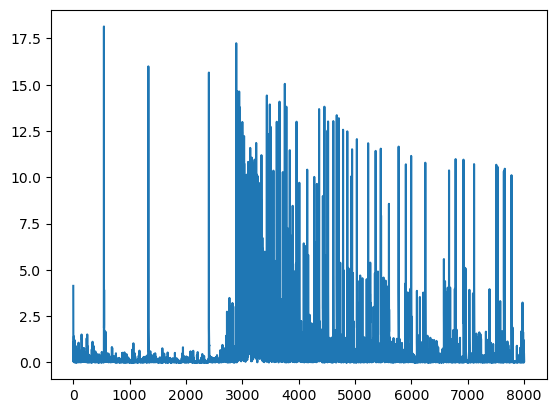

In [5]:
model = SemiGradientSarsa(env_name, alpha=0.15)
model.train(num_episodes=8001, render_every=8000)

In [6]:
states = []
for i in range(2):
    for j in range(5):
        for k in range(5):
            states.append((i, j, k))

policy = {}
V = {}
for state in states:
    policy[state], V[state] = model.get_action(state)

In [7]:
# Convert policy to matrix format
action_mapping = {
    0: 'S',
    1: 'N',
    2: 'E',
    3: 'W',
    4: 'P',
    5: 'D'
}

policy_matrix = np.zeros((2, 5, 5), dtype='<U2')
V_matrix = np.zeros((2, 5, 5))

for ps in range(2):
    for s1 in range(5):
        for s2 in range(5):
            state = (ps, s1, s2)
            policy_matrix[ps, s1, s2] = action_mapping[policy[state]]
            V_matrix[ps, s1, s2] = V[state] 

print('Policy:\n', policy_matrix)
print('Value:\n', V_matrix)

Policy:
 [[['S' 'E' 'E' 'N' 'P']
  ['S' 'E' 'E' 'E' 'N']
  ['D' 'E' 'E' 'E' 'N']
  ['D' 'D' 'E' 'E' 'E']
  ['D' 'D' 'D' 'E' 'E']]

 [['D' 'S' 'S' 'S' 'S']
  ['D' 'S' 'S' 'S' 'S']
  ['D' 'D' 'S' 'S' 'S']
  ['D' 'D' 'D' 'S' 'S']
  ['D' 'D' 'D' 'D' 'W']]]
Value:
 [[[ 1.59247258  4.75366112  7.39535206 10.53143741 17.21881699]
  [ 3.16953745  5.73848069  8.17685451  9.98279767 14.30727824]
  [ 6.38149044  6.51044359  8.67766524 10.09952316 12.07328254]
  [11.85562111  9.76589037  8.89778423  9.86772187  9.97936272]
  [19.38283293 17.03621969 11.5703478   9.28739382  8.76634627]]

 [[ 7.90718633  8.12737276  8.79222738  8.73253582  7.94829806]
  [10.72403601 10.50508741 11.08622435 10.90284524  9.95495008]
  [17.03243981 14.66321998 13.59597173 13.2413793  12.08230096]
  [26.83239775 24.21317955 18.23670351 15.748138   14.33035069]
  [40.12390982 37.24780912 30.54887449 20.0271059  17.13103154]]]


In [8]:
model.test()

State: 287  Action: 2 Reward: -1
State: 187  Action: 1 Reward: -1
State: 87  Action: 1 Reward: -1
State: 99  Action: 4 Reward: -1
State: 199  Action: 0 Reward: -1
State: 299  Action: 0 Reward: -1
State: 399  Action: 0 Reward: -1
State: 499  Action: 0 Reward: -1
State: 479  Action: 3 Reward: -1
State: 475  Action: 5 Reward: 20
Reward: 11


### Semi-Gradient TD(λ)

The key difference between semi-gradient TD(lambda) and semi-gradient Sarsa(0) is that TD(lambda) is a bootstrapping algorithm, whereas Sarsa(0) is a sampling-based algorithm. This means that TD(lambda) uses the estimates of the next state's value to update the value function instead of waiting for the actual next state and reward like Sarsa(0) does.

TD(lambda) also uses a eligibility trace, which is a way to give credit to the previous states that lead to the current state being evaluated. This is done by keeping track of the recent history of states and actions and using them to update the value function. The lambda parameter controls the degree to which credit is given to the previous states, with a higher lambda value giving more credit to earlier states.

In the next section, we'll explore the implementation of semi-gradient TD(lambda) in the Taxi-v3 environment.

Pseudocode:

```
Q(S, A) <-- initial action-value function
Loop for each episode:
    E <-- 0 (eligibility trace)
    S, A <-- initial state and action of episode (e.g., env,reset)
    Loop for each step of episode:
        Take action A, observe R, S'
        Choose A' as a function of Q(S', .) (e.g., epsilon-greedy)
        delta <-- R + gamma * Q(S', A') - Q(S, A) # Calculate TD error
        E(S, A) <-- E(S, A) + 1
        Q(S, A) <-- Q(S, A) + alpha * delta * E(S, A)
        E(S, A) <-- gamma * lambda * E(S, A)
        S <-- S'; A <-- A'
    until S is terminal
```

Reference: Sutton, R.S. and Barto, A.G., 2018. Reinforcement learning: An introduction. MIT press.

In [3]:
import gymnasium as gym
from IPython.display import clear_output
import numpy as np
import time

class semiGradientTD:
    def __init__(self, env_name, alpha=0.1, gamma=0.99, lmbda=0.5):
        self.env_name = env_name
        env = gym.make(env_name)
        self.Q = np.zeros((env.observation_space.n, env.action_space.n))
        self.alpha = alpha
        self.gamma = gamma
        self.lmbda = lmbda
        
    def train(self, episodes=201, max_steps=30, seed=6, render_every=20):
        for i in range(episodes):
            if i % render_every == 0:
                print('Episode:', i)
                env = gym.make(self.env_name, render_mode='human')
            else:
                env = gym.make(self.env_name)
            
            env._max_episode_steps = 30
            observation, info = env.reset(seed = seed)
            done = False
            E = np.zeros((env.observation_space.n, env.action_space.n)) # Eligibility trace
            while not done:
                action = np.argmax(self.Q[observation, :] + np.random.randn(1, env.action_space.n) * (1. / (i + 1)))
                observation_, reward, terminated, truncated, info = env.step(action)
                done = terminated or truncated
                delta = reward + self.gamma * self.Q[observation_, np.argmax(self.Q[observation_, :])] - self.Q[observation, action]
                E[observation, action] += 1
                self.Q += self.alpha * delta * E
                E *= self.gamma * self.lmbda
                observation = observation_
            env.close()
        env.close()

    def test(self, seed=6):
        reward_sum = 0
        env = gym.make(self.env_name, render_mode='human')
        env._max_episode_steps = 30
        observation, info = env.reset(seed=seed)
        done = False
        while not done:
            action = np.argmax(self.Q[observation, :])
            observation_, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            reward_sum += reward
            observation = observation_
            print('State:', observation, ' Action:', action, 'Reward:', reward)
        env.close()
        print('Cummulative Reward: ', reward_sum)

In [4]:
model = semiGradientTD('Taxi-v3')
model.train(render_every=50)

Episode: 0
Episode: 50
Episode: 100
Episode: 150
Episode: 200


In [14]:
model.test()

State: 287  Action: 2 Reward: -1
State: 187  Action: 1 Reward: -1
State: 87  Action: 1 Reward: -1
State: 99  Action: 4 Reward: -1
State: 79  Action: 3 Reward: -1
State: 179  Action: 0 Reward: -1
State: 279  Action: 0 Reward: -1
State: 379  Action: 0 Reward: -1
State: 479  Action: 0 Reward: -1
State: 475  Action: 5 Reward: 20
Cummulative Reward:  11


## Results
Both algorithms performed well in the Taxi-v3 environment, and were able to successfully drop the passenger. The semi-gradient TD(lambda) algorithm performed equal to the semi-gradient Sarsa(0) algorithm, achieving a cummulative reward of 11. However semi-gradient TD(lambda) required significantly less episodes to reach convergence. This is likely due to the fact that TD(lambda) is a bootstrapping algorithm, which means that it uses the estimates of the next state's value to update the value function instead of waiting for the actual next state and reward like Sarsa(0) does.